# Import, resize and save image files as .csv

This notebook does the following:

1. Obtains all filename and file paths of files ending with .jpg
2. Extracts label of the image: whether it is pathological or healthy from the file name
3. Saves file names, paths and labels into a .csv

4. Reading and saving images: 
    * Reads images one at a time, 
    * resizes them to be smaller, 
    * converts them to numpy arrays
    * unravels them to be a single vector
    * appends the vectors to a dataframe along with metadata about file and label, and 
    * saves a .csv of this clean dataset 

**Library Imports**

In [186]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from scipy.ndimage import uniform_filter
from plotly import figure_factory as ff

In [160]:
# get file paths for importing data
file_paths = glob.glob('../data/Images/*.jpg')

get file names and labels: pathological images have file names with `_g_` in them. Images of healthy retinas do not. For instance: 
* `Im001_ACRIMA.jpg` : healthy retina
* `Im696_g_ACRIMA.jpg`: retina with glaucoma


In [161]:
file_name = [Path(directory).name for directory in file_paths]

In [162]:
# get labels
label = [1 if '_g_' in name else 0 for name in file_name]

In [163]:
# create a dataframe and save to .csv for future use
files = pd.DataFrame({'file_path' : file_paths,
                      'file_name': file_name,
                      'label' : label})

# uncomment to save file to csv
# files.to_csv('../data/file_names.csv', index=False) 

**Look at a sample of images from both classes**

In [169]:
glaucoma_images = files[files['label']==1]['file_path'].sample(5)
healthy_images = files[files['label']==0]['file_path'].sample(5)

In [174]:
glaucoma_images

,file_path
0,../data/Images\Im650_g_ACRIMA.jpg
1,../data/Images\Im485_g_ACRIMA.jpg
2,../data/Images\Im555_g_ACRIMA.jpg
3,../data/Images\Im496_g_ACRIMA.jpg
4,../data/Images\Im621_g_ACRIMA.jpg


In [171]:
glaucoma_images.to_csv('../data/glaucoma_images.csv', index=False)
healthy_images.to_csv('../data/healthy_images.csv', index=False)

In [172]:
glaucoma_images = pd.read_csv('../data/glaucoma_images.csv')
healthy_images = pd.read_csv('../data/healthy_images.csv')

In [180]:
for f in glaucoma_images['file_path']:
    print(f)

../data/Images\Im650_g_ACRIMA.jpg
../data/Images\Im485_g_ACRIMA.jpg
../data/Images\Im555_g_ACRIMA.jpg
../data/Images\Im496_g_ACRIMA.jpg
../data/Images\Im621_g_ACRIMA.jpg


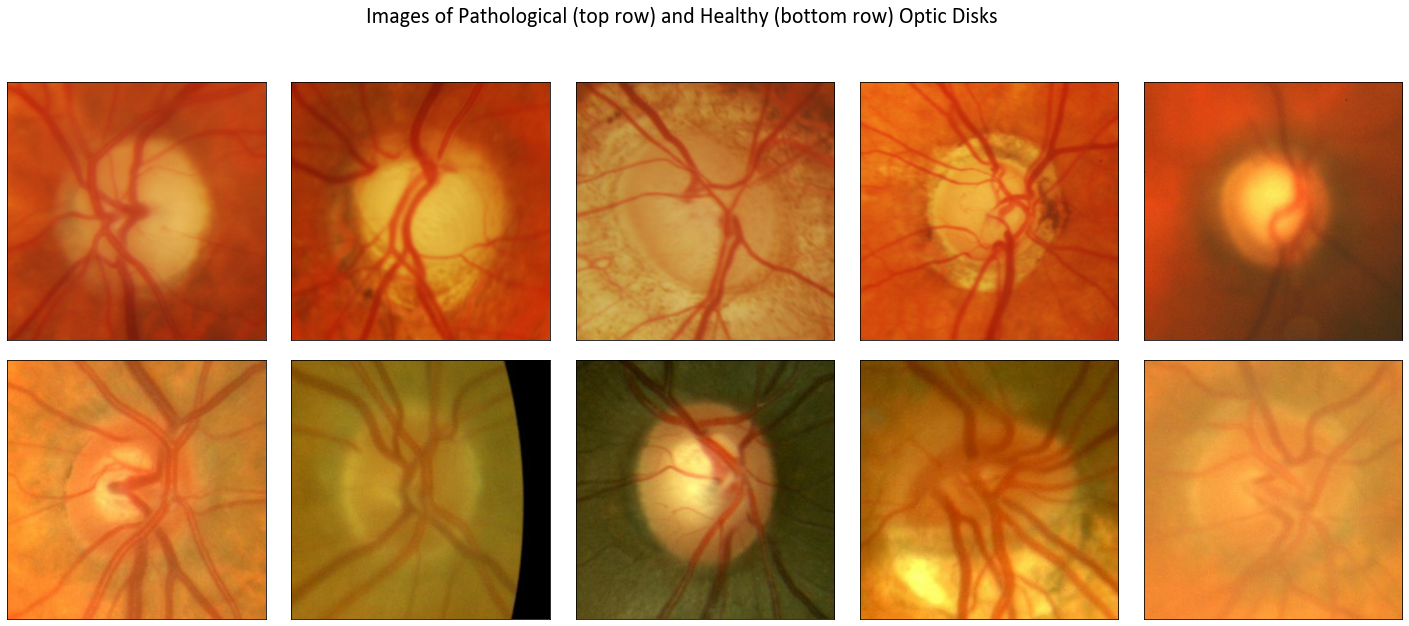

In [181]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
fig.suptitle('Images of Pathological (top row) and Healthy (bottom row) Optic Disks', 
             size=22)

plt.rcParams.update({'font.sans-serif':'Calibri'})

plt.subplots_adjust(wspace=0.1,
                   hspace=0.05)

for i, f in enumerate(glaucoma_images['file_path']):
    ax[0,i].imshow(Image.open(f))
    ax[0,i].set_title(r"$\bf{Glaucoma: }$" + f"{Path(f).name[0:5]}", size=14, color='white')
    ax[0,i].tick_params(
        axis='both',      
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False) 

for i, f in enumerate(healthy_images['file_path']):
    ax[1,i].imshow(Image.open(f))
    ax[1,i].set_title(r"$\bf{Healthy: }$" + f"{Path(f).name[0:5]}", size=14, color='white')
    ax[1,i].tick_params(
        axis='both',      
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False) 

# uncomment below to save figure    
# plt.savefig('../figures/sample_images.png', bbox_inches='tight', dpi='figure')

**Plot distributions of pixel values for sets of sample images from both classes**

In [182]:
glaucoma_images = files[files['label']==1]['file_path'].sample(100)
healthy_images = files[files['label']==0]['file_path'].sample(100)
pixels_g = []
pixels_h = []
for i, f in enumerate(glaucoma_images):
    pixels_g = np.concatenate((pixels_g, np.asarray(Image.open(f).resize((178,178))).ravel()))

for i, f in enumerate(healthy_images):
    pixels_h = np.concatenate((pixels_h, np.asarray(Image.open(f).resize((178,178))).ravel()))

In [183]:
pixels_df = pd.DataFrame({'pixels':np.concatenate((pixels_g, pixels_h)),
                          'label':np.concatenate((['Glaucoma']*len(pixels_g),(['Healthy']*len(pixels_h))))})

In [184]:
pixels_df

,pixels,label
0,143.0,Glaucoma
1,60.0,Glaucoma
2,16.0,Glaucoma
3,142.0,Glaucoma
4,59.0,Glaucoma
...,...,...
19010395,42.0,Healthy
19010396,1.0,Healthy
19010397,102.0,Healthy
19010398,40.0,Healthy


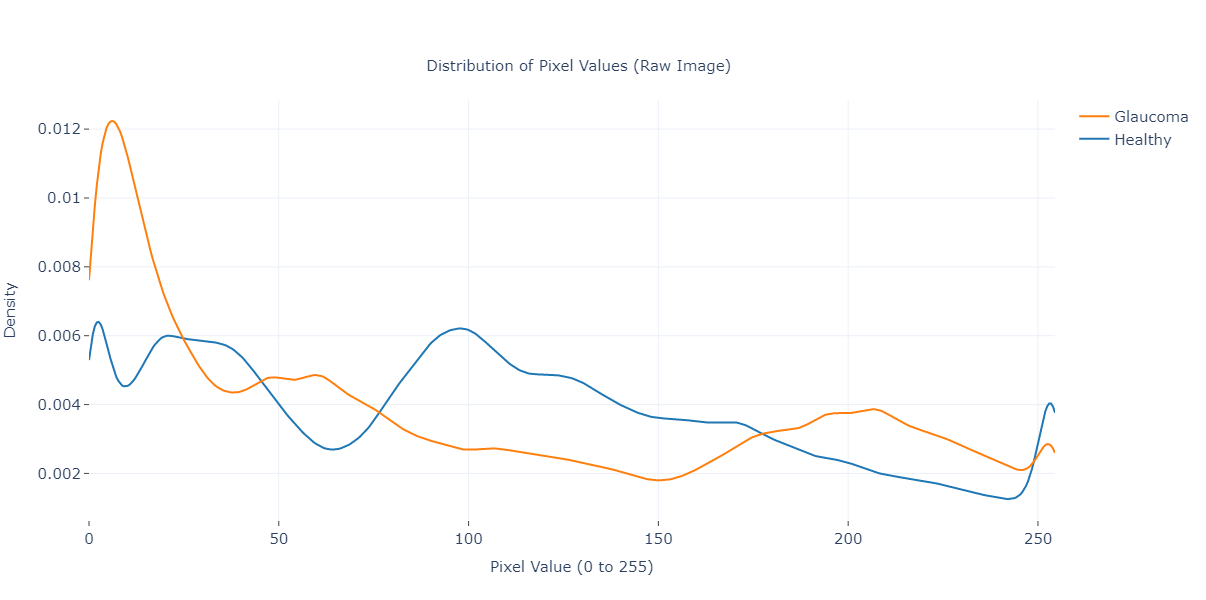

In [220]:
hist_data = [pixels_df[pixels_df['label']=='Healthy']['pixels'], pixels_df[pixels_df['label']=='Glaucoma']['pixels']]
group_labels = ['Healthy', 'Glaucoma']
colors = ['#1f77b4', '#ff7f0e']


fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Distribution of Pixel Values (Raw Image)',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 255)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

In [222]:
# extract data from fig to draw line plot

pixels_dist_raw = pd.DataFrame({
    'Healthy':fig.data[0]['y'],
    'Glaucoma': fig.data[1]['y'],
    'Density':fig.data[0]['x']
})


pixels_dist_raw = pd.melt(pixels_dist_raw, id_vars='Density', value_vars=pixels_dist_raw.columns[:])
pixels_dist_raw.to_csv('../data/pixels_dist_raw.csv', index=False)

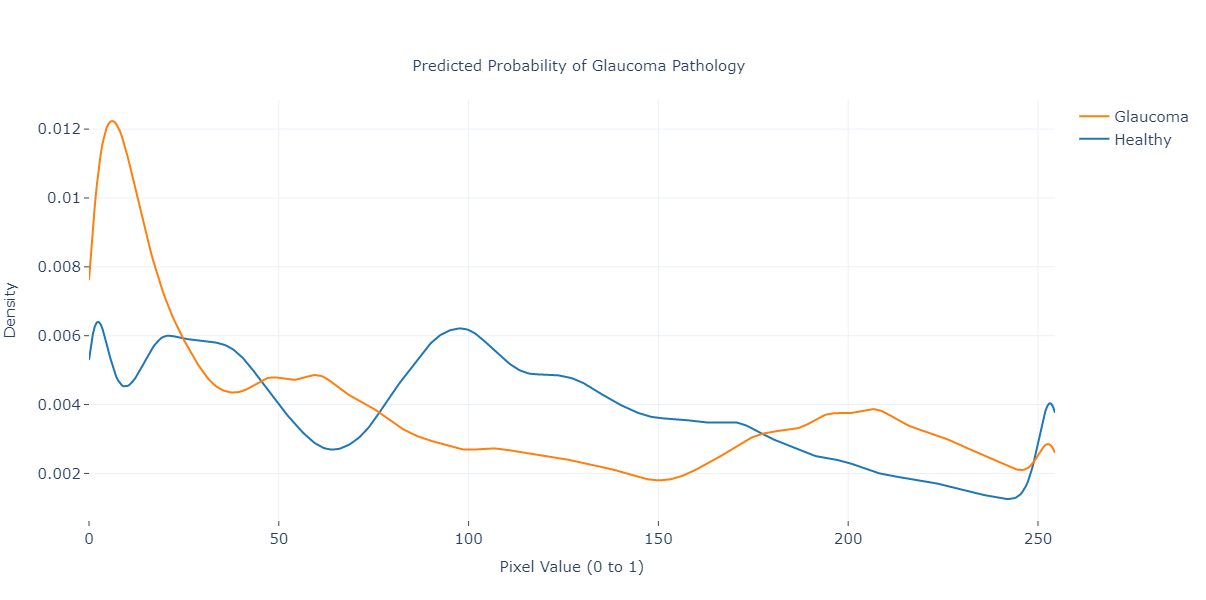

In [225]:
px.line(data_frame=pixels_dist_raw, x='value', y='Density', color='variable', color_discrete_sequence=['#1f77b4', '#ff7f0e'])

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

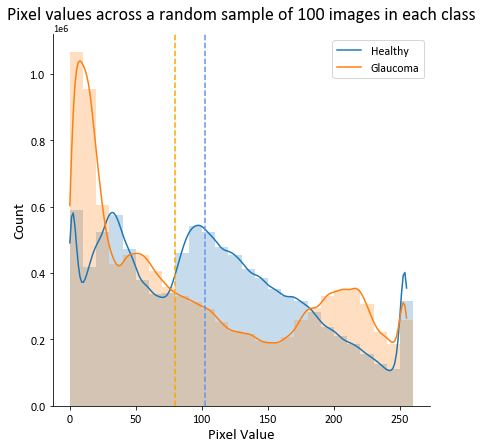

In [122]:
# establish palette so Glaucoma is always orange
palette = {"Healthy":"tab:blue",
           "Glaucoma":"tab:orange"}

# set up font for plot
plt.rcParams.update({'font.sans-serif':'Calibri'})

# plot
sns.displot(data=pixels_df, 
            x='pixels', 
            hue='label',    # assign colors based on label
            kind='hist',    # plot histogram
            binwidth=10, 
            kde=True,       # also plot kde
            element='step', # plot histogram as step
            height=6, 
            legend=False,   # don't plot legend
            palette=palette,# use palette to assign colors
            edgecolor=None) # don't draw dark line around histogram

# add median lines
plt.axvline(pixels_df.groupby('label').median().loc['Glaucoma'].values[0], 
            ymax=800_500, linestyle='dashed', color='orange')

plt.axvline(pixels_df.groupby('label').median().loc['Healthy'].values[0], 
            ymax=800_500, linestyle='dashed', color='cornflowerblue')

# labels and title
plt.legend(['Healthy', 'Glaucoma'], fontsize=12)
plt.xlabel('Pixel Value', size=15)
plt.ylabel('Count', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pixel values across a random sample of 100 images in each class', size=18, y=1, pad=15);

# uncomment below to save figure    
plt.savefig('../figures/pixel_distribution.png', bbox_inches='tight', dpi=300)

In [199]:
glaucoma_pixels = []

for f in glaucoma_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    
np.shape(glaucoma_pixels)

avg=pd.DataFrame(glaucoma_pixels).mean().values

In [146]:
# np.save('../data/avg_pixel_val_glaucoma.npy', avg)

In [155]:
max(avg)

0.77777296

In [191]:
np.shape(np.ravel(glaucoma_pixels))

(9505200,)

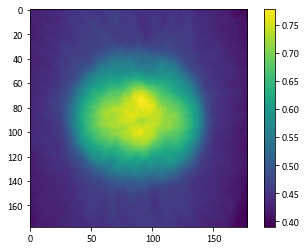

In [147]:
plt.imshow(avg.reshape((178,178)))
plt.colorbar()

In [200]:
healthy_pixels = []

for f in healthy_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    

avg=pd.DataFrame(healthy_pixels).mean().values

In [144]:
np.save('../data/avg_pixel_val_healthy.npy', avg)

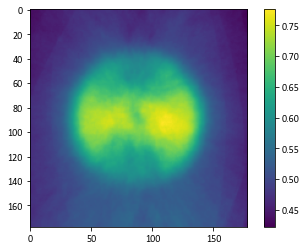

In [143]:
plt.imshow(avg.reshape((178,178)))
plt.colorbar();

In [150]:
from plotly import express as px
from plotly import figure_factory as ff

In [201]:
hist_data = [np.ravel(healthy_pixels), np.ravel(glaucoma_pixels)]
group_labels = ['Healthy', 'Glaucoma']
colors = ['#1f77b4', '#ff7f0e']


fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

In [205]:
fig.data

(Scatter({
     'legendgroup': 'Healthy',
     'marker': {'color': '#1f77b4'},
     'mode': 'lines',
     'name': 'Healthy',
     'showlegend': True,
     'x': [0.0, 0.002, 0.004, ..., 0.994, 0.996, 0.998],
     'xaxis': 'x',
     'y': array([0.73370342, 0.75742937, 0.76253288, ..., 1.11043085, 1.08449754,
                 1.03085528]),
     'yaxis': 'y'
 }),
 Scatter({
     'legendgroup': 'Glaucoma',
     'marker': {'color': '#ff7f0e'},
     'mode': 'lines',
     'name': 'Glaucoma',
     'showlegend': True,
     'x': [0.0, 0.002, 0.004, ..., 0.994, 0.996, 0.998],
     'xaxis': 'x',
     'y': array([0.5720842 , 0.58764057, 0.59178239, ..., 0.82199528, 0.79199674,
                 0.74844992]),
     'yaxis': 'y'
 }))

In [210]:
pixels_dist_normalized = pd.DataFrame({
    'Healthy':fig.data[0]['y'],
    'Glaucoma': fig.data[1]['y'],
    'Density':fig.data[0]['x']
})
pixels_dist_normalized


,Healthy,Glaucoma,Density
0,0.733703,0.572084,0.000
1,0.757429,0.587641,0.002
2,0.762533,0.591782,0.004
3,0.751850,0.586062,0.006
4,0.729741,0.572853,0.008
...,...,...,...
495,1.081609,0.842425,0.990
496,1.108644,0.838429,0.992
497,1.110431,0.821995,0.994
498,1.084498,0.791997,0.996


In [212]:
pixels_dist_normalized=pd.melt(pixels_dist_normalized, id_vars='Density', value_vars=pixels_dist_normalized.columns[:])

In [213]:
pixels_dist_normalized.head(1)

,Density,variable,value
0,0.0,Healthy,0.733703


In [216]:
pixels_dist_normalized.to_csv('../data/pixels_distribution_normalized.csv', index=False)

In [217]:
pixels_dist_normalized = pd.read_csv('../data/pixels_distribution_normalized.csv')
pixels_dist_normalized.head(2)

,Density,variable,value
0,0.000,Healthy,0.733703
1,0.002,Healthy,0.757429


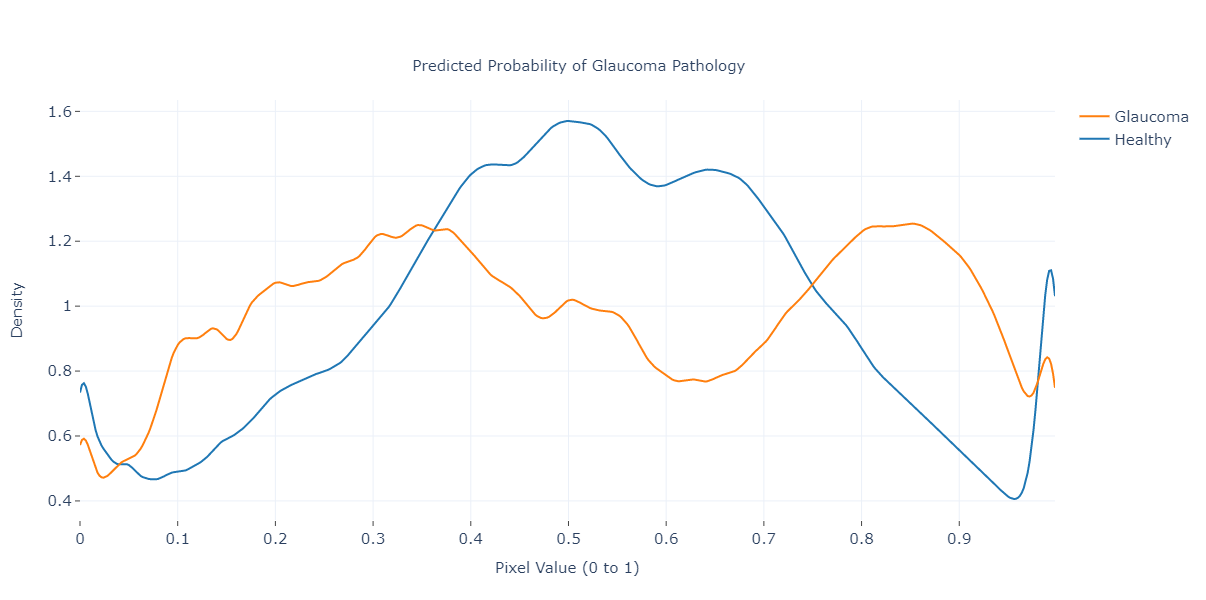

In [218]:
px.line(data_frame=pixels_dist_normalized, x='value', y='Density', color='variable', color_discrete_sequence=['#1f77b4', '#ff7f0e'])

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

**Import images and convert to numpy array**

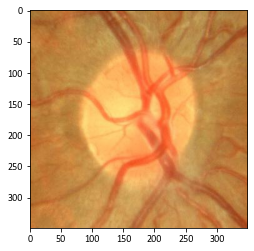

In [226]:
# check if numpy array can still be used as an image
x = np.asarray(Image.open(files['file_path'][0]))
plt.imshow(x)

In [227]:
# Check how to `.ravel()` and `.reshape()`
# unravel image tobe a vector
shape = x.shape
y = x.ravel()

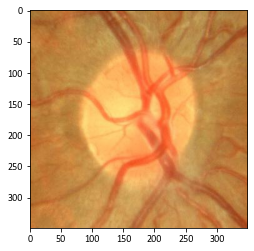

In [228]:
# reshape it back to the shape it was a plot it
plt.imshow(y.reshape(shape))

**Create dataframe with image array in it**

In [229]:
# Create a dataframe with fields: file path, file name, label, image and image shape

data_df = files.copy()
shape = []                                    # create an empty list to put shape of every image 
image = []                                    # crate empty list to store image

In [230]:
data_df.head()

,file_path,file_name,label
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0
3,../data/Images\Im004_ACRIMA.jpg,Im004_ACRIMA.jpg,0
4,../data/Images\Im005_ACRIMA.jpg,Im005_ACRIMA.jpg,0


**All my images are of different sizes, so I will resize them to be the same size as the smallest image** 

In [231]:
# find the size of smallest image
im_size = []
for f in data_df['file_path']:
    im = Image.open(f)
    im_size.append(im.size)
min_size = min(im_size)

In [232]:
h = [h for h,w in im_size]
w = [w for h,w in im_size]

In [235]:
sizes_df = pd.DataFrame({'h':h, 'w':w})
sizes_df['label'] = files['label']
sizes_df['label'].replace({1:'Glaucoma', 0:'Healthy'}, inplace=True)
sizes_df['ratio'] = sizes_df['h']/sizes_df['w']
sizes_df.head()

,h,w,label,ratio
0,349,349,Healthy,1.0
1,277,277,Healthy,1.0
2,409,409,Healthy,1.0
3,406,406,Healthy,1.0
4,316,316,Healthy,1.0


In [237]:
sizes_df[sizes_df['label']=='Healthy']['ratio'].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [234]:
sizes_df.to_csv('../data/image_sizes.csv', index=False)

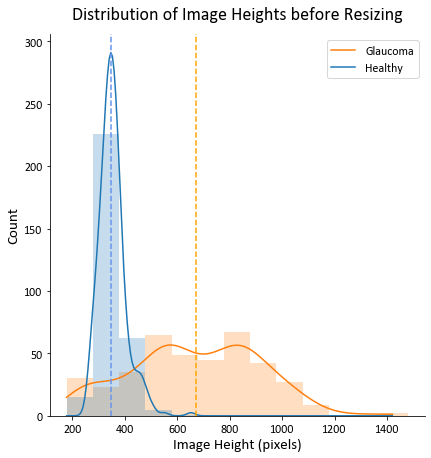

In [19]:
# establish palette so Glaucoma is always orange
palette = {"Healthy":"tab:blue",
           "Glaucoma":"tab:orange"}

# set up font for plot
plt.rcParams.update({'font.sans-serif':'Calibri'})

# plot
sns.displot(data=sizes_df, 
            x='h', 
            hue='label',    # assign colors based on label
            kind='hist',    # plot histogram
            binwidth=100, 
            kde=True,       # also plot kde
            element='step', # plot histogram as step
            height=6, 
            legend=False,   # don't plot legend
            palette=palette,# use palette to assign colors
            edgecolor=None) # don't draw dark line around histogram

# add median lines
plt.axvline(sizes_df.groupby('label').median().loc['Glaucoma'].values[0], 
            ymax=240, linestyle='dashed', color='orange')

plt.axvline(sizes_df.groupby('label').median().loc['Healthy'].values[0], 
            ymax=240, linestyle='dashed', color='cornflowerblue')

# labels and title
plt.legend(['Glaucoma', 'Healthy'], fontsize=12)
plt.xlabel('Image Height (pixels)', size=15)
plt.ylabel('Count', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Image Heights before Resizing', size=18, y=1, pad=15);

# uncomment below to save figure    
plt.savefig('../figures/size_distribution.png', bbox_inches='tight', dpi=300)

<bound method FacetGrid.refline of <seaborn.axisgrid.FacetGrid object at 0x0000016EA252FAF0>>

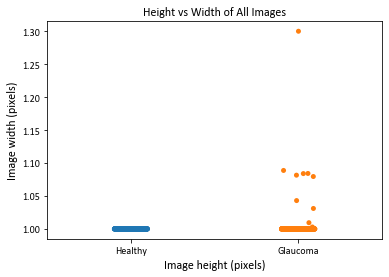

In [125]:
sns.stripplot(data=sizes_df, x='label', y='ratio')
plt.xlabel('Image height (pixels)', size=12)
plt.ylabel('Image width (pixels)', size=12)
plt.title('Height vs Width of All Images');

# uncomment below to save figure    
plt.savefig('../figures/sizes_ratios.png', bbox_inches='tight', dpi='figure')

In [21]:
min_size

(178, 178)

Pixel values for original image range between 0 and 255
Pixel values for resized image range between 0 and 255


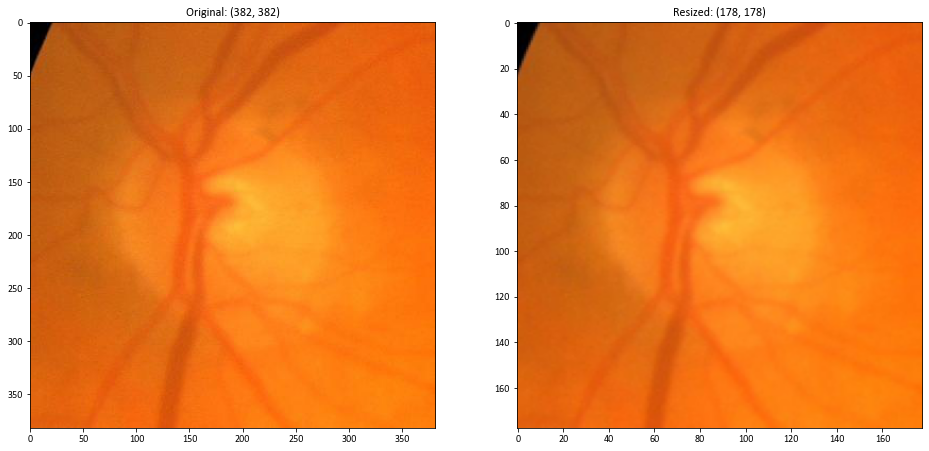

In [126]:
# double check to make sure that the resized image is not visibly reduced in quality
f = files['file_path'].sample(1).values[0]
im = Image.open(f)
print(f"Pixel values for original image range between {np.asarray(im).min()} and {np.asarray(im).max()}")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(im)
ax[0].set_title(f'Original: {im.size}')

im = im.resize((178, 178))
print(f"Pixel values for resized image range between {np.asarray(im).min()} and {np.asarray(im).max()}")
ax[1].imshow(im)
ax[1].set_title(f'Resized: {im.size}');

    

**Create dataframe**

In [33]:
# for every image in the list:
for f in data_df['file_path']:
    im = Image.open(f)       # open image
    im = im.resize(min_size) # resize to size of smallest image
    im = np.asarray(im)      # convert to array
    shape.append(im.shape)   # save shape of array
    im = im.ravel()          # convert 3D array to a vector
    image.append(im)         # append to list

In [35]:
data_df['shape'] = shape
data_df.head()

,file_path,file_name,label,shape
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)"
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)"
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)"
3,../data/Images\Im004_ACRIMA.jpg,Im004_ACRIMA.jpg,0,"(178, 178, 3)"
4,../data/Images\Im005_ACRIMA.jpg,Im005_ACRIMA.jpg,0,"(178, 178, 3)"


In [77]:
# convert the list image to an numpy array 
image = np.array(image)

In [78]:
# convert the list of image arrays into a dataframe. This will place each pixel value in a separate column
# then concatenate it to the dataframe with the other details about the image
data_df = pd.concat([data_df, pd.DataFrame(image)], axis=1)
data_df.head()

,file_path,file_name,label,shape,0,1,2,3,4,5,...,95042,95043,95044,95045,95046,95047,95048,95049,95050,95051
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)",162,115,50,163,115,51,...,34,167,72,34,168,71,33,163,67,28
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)",144,108,56,145,109,57,...,25,145,75,26,145,75,26,146,76,27
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)",254,155,26,254,156,27,...,51,220,146,51,220,146,52,219,146,52
3,../data/Images\Im004_ACRIMA.jpg,Im004_ACRIMA.jpg,0,"(178, 178, 3)",162,76,1,162,79,1,...,1,159,52,0,159,54,0,161,55,0
4,../data/Images\Im005_ACRIMA.jpg,Im005_ACRIMA.jpg,0,"(178, 178, 3)",179,87,2,179,87,2,...,11,177,108,13,178,109,14,178,109,14


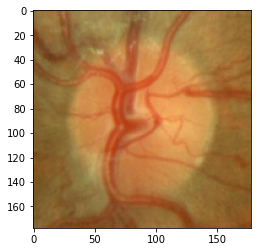

In [87]:
# test to make sure data is preserved
# to break that down: 
    # data_df.drop(columns=['file_path', 'file_name', 'label', 'shape']) removes all non-pixel columns
    # .iloc[1,:].values accesses the first row of pixels, i.e, the first image
    # .reshape((178, 178, 3)) reshapes it back to an image from a vector

plt.imshow(data_df.drop(columns=['file_path', 'file_name', 'label', 'shape']).iloc[1,:].values.reshape((178, 178, 3)));


In [85]:
# uncomment to save dataframe to disk as .csv
data_df.to_csv('../data/clean_data.csv', index=False)